<a href="https://colab.research.google.com/github/crushedtiggy/SMT203_Tweets_Sentiment_Analysis/blob/main/Twitter_Sentiment_Analysis%20(LA%20Tweets%201).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Add Google Drive as an accessible path (Optional if you are running from Jupyter Notebook)
from google.colab import drive
drive.mount('/content/drive')

# change path to the designated google drive folder
# otherwise, data will be saved in /content folder which you may have issue locating
%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [ ]:
# For lazy people who find it troublesome to change the fixed variables
tweets = input("Type which tweets to analyse (e.g. tweets.csv): ")
state = input("Type state: ")
num = input("Type num: ")
start_date = input("Type start date in the following format (e.g. Jan 2020): ")
end_date = input("Type end date in the following format (e.g. Jan 2020): ")

Type which tweets to analyse (e.g. tweets.csv): LA_tweets1.csv
Type state: Los Angeles
Type num: 1
Type start date in the following format (e.g. Jan 2020): Jan 2017
Type end date in the following format (e.g. Jan 2020): Dec 2017


In [ ]:
import pandas as pd
tweets_df = pd.read_csv(tweets)

In [ ]:
tweets_df

,Unnamed: 0,url,date,content,id,username,outlinks,outlinksss,tcooutlinks,tcooutlinksss
0,0,https://twitter.com/MonteroOnBoxing/status/947...,2017-12-30 23:55:05+00:00,"@moose_ali ""that much"" attention? Maybe not. ...",947254748318543872,MonteroOnBoxing,[],NaN,[],NaN
1,1,https://twitter.com/startrekker/status/9471525...,2017-12-30 17:09:01+00:00,@LisaCassandra1 @sbhopper8 @onesarahjones @ggr...,947152557658402816,startrekker,[],NaN,[],NaN
2,2,https://twitter.com/Mariapalestina/status/9471...,2017-12-30 14:35:25+00:00,Where is the #MeToo movement for Ahed Tamimi –...,947113903166648321,Mariapalestina,['http://mondoweiss.net/2017/12/where-movement...,http://mondoweiss.net/2017/12/where-movement-t...,['https://t.co/r3Hoq7vVK7'],https://t.co/r3Hoq7vVK7
3,3,https://twitter.com/AshleyRiegle/status/946990...,2017-12-30 06:23:27+00:00,Cozy night in by the Christmas tree reading th...,946990092907790336,AshleyRiegle,[],NaN,[],NaN
4,4,https://twitter.com/Casanvar/status/9469816149...,2017-12-30 05:49:45+00:00,Where is the #MeToo movement for Ahed Tamimi –...,946981614986305536,Casanvar,['http://mondoweiss.net/2017/12/where-movement...,http://mondoweiss.net/2017/12/where-movement-t...,['https://t.co/YpfC2jCRcO'],https://t.co/YpfC2jCRcO
...,...,...,...,...,...,...,...,...,...,...
1738,1738,https://twitter.com/Kelli_Dawn/status/82045813...,2017-01-15 02:30:37+00:00,"@Nino7681 yes I concur. However, take some com...",820458135592701952,Kelli_Dawn,[],NaN,[],NaN
1739,1739,https://twitter.com/stealthhawk/status/8198235...,2017-01-13 08:29:10+00:00,@DailyDoseOfLos #MeToo off #Amazon,819823593152397314,stealthhawk,[],NaN,[],NaN
1740,1740,https://twitter.com/BrodyismeFriend/status/819...,2017-01-11 19:46:52+00:00,@DanMarganski thanks pal! #meToo,819269364859813889,BrodyismeFriend,[],NaN,[],NaN
1741,1741,https://twitter.com/blooyum/status/81760595292...,2017-01-07 05:37:04+00:00,LMAO #Metoo https://t.co/U88q1KU3Mz,817605952929026049,blooyum,['https://twitter.com/jendgaf_/status/81759631...,https://twitter.com/jendgaf_/status/8175963141...,['https://t.co/U88q1KU3Mz'],https://t.co/U88q1KU3Mz


In [ ]:
import re 
import string
from string import punctuation

def clean_text_round1(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)
    tweet = tweet.lower()
    return tweet

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
def clean_text_round2(text):
    return ' '.join([word for word in text.split() if word not in (stop)])

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def clean_text_round3(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    return ' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split()]) 

def do_cleaning(df):
  df['clean_text_1'] = df['content'].apply(clean_text_round1)
  df['clean_text_2'] = df['clean_text_1'].apply(clean_text_round2)
  df['clean_text_3'] = df['clean_text_2'].apply(clean_text_round3)
  return df

def count_words_from_dataframe(df): #we are basically trying to return a count of tokenized words
    result_dict = {}
    # iterate rows of dataframe 
    for index, row in df.iterrows():
        text = row['clean_text_3']
        
        # this will split a sentence into words 
        tokens = text.split()
        tokens = set(tokens) # - modified this from the lab so that each tweet only gives one related word
        
        # iterate each word 
        for token in tokens:
          if token in (punctuation  + '’'):
            pass
          else:
            try:
                result_dict[token] += 1
            except KeyError:
                result_dict[token] = 1
                    
    return result_dict

import csv
def do_unigram(df, state, num):
  count_type = 'unigram'

  ## query helps to filter rows of dataframe given a condition 
  result = count_words_from_dataframe(df) 
  print(result)
  ## soring the words based on their frequency
  sorted_dic = ((k, result[k]) for k in sorted(result, key=result.get, reverse=True))

  ## write the dictionary in a file
  with open("./metoo_"+ state + "_unigrams_" + num + ".csv", 'w') as fp:
      writer = csv.writer(fp, delimiter=',')
      writer.writerows(sorted_dic) #write the sorted dict into the csv file

  count_df = pd.read_csv("./metoo_"+ state + "_unigrams_" + num + ".csv",header=None)
  count_df = count_df[count_df[0] != '']
  count_df = count_df[count_df[0] != '']
  count_df = count_df.rename(columns={1: 'Count', 0: 'Keywords'})
  count_df = count_df.head(10)

  return count_df[count_df['Keywords'] != 'metoo']

import plotly.express as px
def do_countbar(df, state, start_year, end_year):
  fig = px.bar(count_df,y='Count',x='Keywords',color='Count',title="Top keywords found in #MeToo " + state +  " from " + start_year + " to " + end_year)
  fig.update_layout(bargap=0.2)
  fig.show()

from wordcloud import WordCloud, STOPWORDS

def makeImage(termDict):
    
    wc = WordCloud(max_font_size=60, width=1680, height=1000, background_color="white")    

    ### generate word cloud using frequencies!
    wc.generate_from_frequencies(termDict)

    ### show the figure
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show() 

!pip install text2emotion
import text2emotion as te
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
nltk.download('vader_lexicon')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def sentiment_analysis(df, state, start_year, end_year):
  sentiment_ratio_list = [] 

  for index, row in df['clean_text_3'].iteritems():
    score = te.get_emotion(row)
    ang = score['Angry']
    fea = score['Fear']
    sad = score['Sad']
    hap = score['Happy']
    sur = score['Surprise']
    df.loc[index, 'Angry'] = ang
    df.loc[index, 'Fear'] = fea
    df.loc[index, 'Sad'] = sad
    df.loc[index, 'Happy'] = hap
    df.loc[index, 'Surprise'] = sur
    emo = max(score, key = score.get)
    df.loc[index, 'emotion'] = emo

  for index, row in df['clean_text_3'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    df.loc[index,'negative'] = neg
    df.loc[index,'netural'] = neu
    df.loc[index,'positive'] = pos
    df.loc[index,'vader_polarity'] = comp
    if neg > pos:
        df.loc[index,'sentiment'] = 'negative'
    elif pos > neg:
        df.loc[index,'sentiment'] = 'positive'
    else:
        df.loc[index, 'sentiment'] = 'neutral'
    polar = TextBlob(row).sentiment.polarity
    subject = TextBlob(row).sentiment.subjectivity
    df.loc[index,'tb_polarity'] = polar
    df.loc[index,'subjectivity'] = subject

    df['location'] = state

    df.to_csv(f'Twitter_MeToo_' + state + '_' + start_year + ' to ' + end_year + '.csv',index=False)

  temp = []
  for index,row in df.iterrows():
    if type(row['clean_text_3']) == float: #remove items that have NAN as clean_text_3
      temp.append(index)

  df.drop(temp)
  df = df.drop(temp)

  try:
    angry_sum = df['emotion'].value_counts()['Angry']
  except KeyError: 
    angry_sum = 0
  angry_average_ = angry_sum/len(df.index)

  try:
    sad_sum = df['emotion'].value_counts()['Sad']
  except KeyError: 
    sad_sum = 0
  sad_average_ = sad_sum/len(df.index)

  try:
    fear_sum = df['emotion'].value_counts()['Fear']
  except KeyError: 
    fear_sum = 0
  fear_average_ = fear_sum/len(df.index)

  try:
    happy_sum = df['emotion'].value_counts()['Happy']
  except KeyError: 
    happy_sum = 0
  happy_average_ = happy_sum/len(df.index)

  try:
    sur_sum = df['emotion'].value_counts()['Surprise']
  except KeyError:
    sur_sum = 0
  sur_average_ = sur_sum/len(df.index)

  df_emotion_aggregated = pd.DataFrame({'Emotion': ['happy', 'sad', 'surprise', 'angry', 'fear'],
                    'Value': [happy_average_, sad_average_, sur_average_, angry_average_, fear_average_]})

  df_emotion_aggregated #aggregated means that we take the most common emotion in each post as a measurement

  angry_sum = 0
  for index, row in df['Angry'].iteritems():
    angry_sum += row
    angry_average_2011 = angry_sum/len(df.index)
    
  sad_sum = 0
  for index, row in df['Sad'].iteritems():
    sad_sum += row
    sad_average_2011 = sad_sum/len(df.index)

  fear_sum = 0
  for index, row in df['Fear'].iteritems():
    fear_sum += row
    fear_average_2011 = fear_sum/len(df.index)

  happy_sum = 0
  for index, row in df['Happy'].iteritems():
    happy_sum += row
    happy_average_2011 = happy_sum/len(df.index)

  sur_sum = 0
  for index, row in df['Sad'].iteritems():
    sur_sum += row
    sur_average_2011 = sur_sum/len(df.index)

  df_emotion_specific = pd.DataFrame({'Emotion': ['happy', 'sad', 'surprise', 'angry', 'fear'],
                    'Value': [happy_average_2011, sad_average_2011, sur_average_2011, angry_average_2011, fear_average_2011]})

  df_emotion_specific #specific means we take into account the specific differences in emotion value across all categories


  # theta has 5 different angles, and the first one repeated
  theta = np.arange(len(df_emotion_aggregated) + 1) / float(len(df_emotion_aggregated)) * 2 * np.pi

  fig = plt.figure(figsize=(20,16))
  ax1 = fig.add_subplot(221, projection="polar")
  # values has the 5 values from 'Col B', with the first element repeated
  values = df_emotion_aggregated['Value'].values
  values = np.append(values, values[0])

  # draw the polygon and the mark the points for each angle/value combination
  l1, = ax1.plot(theta, values, color="C2", marker="o", label="Value")
  plt.xticks(theta[:-1], df_emotion_aggregated['Emotion'], color='grey', size=8)
  ax1.tick_params(pad=5) # to increase the distance of the labels to the plot
  # fill the area of the polygon with green and some transparency
  ax1.fill(theta, values, 'green', alpha=0.1)
  plt.legend() # shows the legend, using the label of the line plot (useful when there is more than 1 polygon)
  plt.title("Emotion Analysis " + start_year + " to " + end_year + " aggregated\n") 

  ax2 = fig.add_subplot(222, projection="polar")
  # values has the 5 values from 'Col B', with the first element repeated
  values = df_emotion_specific['Value'].values
  values = np.append(values, values[0])

  # draw the polygon and the mark the points for each angle/value combination
  l2, = ax2.plot(theta, values, color="C2", marker="o", label="Value")
  plt.xticks(theta[:-1], df_emotion_specific['Emotion'], color='grey', size=8)
  ax2.tick_params(pad=5) # to increase the distance of the labels to the plot
  # fill the area of the polygon with green and some transparency
  ax2.fill(theta, values, 'green', alpha=0.1)
  plt.legend() # shows the legend, using the label of the line plot (useful when there is more than 1 polygon)
  plt.title("Emotion Analysis " + start_year + " to " + end_year + " spread \n")
  plt.show()

  import operator

def frequent_words(df, start_year, end_year):
  result = count_words_from_dataframe(df)   
  sorted_list = [(k, result[k]) for k in sorted(result, key=result.get, reverse=True)]
  uni_df = pd.DataFrame (sorted_list, columns = ['unigram', 'count'])
  uni_df = uni_df[uni_df['unigram'] != 'metoo']
  uni_mod = uni_df.head(20)

  import plotly.express as px
  fig = px.bar(uni_mod,y='count',x='unigram',color='unigram',title="Most frequented words used from " + start_year + " to " + end_year)
  fig.update_layout(bargap=0.2)
  fig.show()

  uni_dict = uni_mod.set_index('unigram')['count'].to_dict()

  makeImage(uni_dict)

def scores(df):
  score = 0
  for row in df['vader_polarity']:
    score += row
    vader_polarity = score/len(df.index)

  score1 = 0
  for row in df['tb_polarity']:
    score1 += row
    tb_polarity = score1/len(df.index)

  return [vader_polarity,tb_polarity]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 57 kB 2.6 MB/s 
     |████████████████████████████████| 170 kB 8.9 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=b43baba63c805fdceea40dae2b2a26b97baf3747093325406205b385f7f58071
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [ ]:
cleaned_df = do_cleaning(tweets_df)

In [ ]:
count_df = do_unigram(cleaned_df, state, num)

{'talkedtweeted': 1, 'one': 62, 'youd': 1, 'im': 41, 'figure': 2, 'ali': 1, 'attention': 6, 'era': 2, 'metoo': 1709, 'garner': 1, 'buzz': 1, 'thats': 9, 'yes': 20, 'would': 38, 'much': 18, 'medium': 8, 'least': 4, 'maybe': 9, 'plenty': 1, 'vicious': 1, 'don’t': 29, 'assume': 2, 'back': 22, 'experience': 17, 'tamimi': 2, 'ahed': 2, 'list': 10, 'movement': 62, 'mondoweiss': 2, '–': 2, 'christmas': 3, 'woman': 191, 'cozy': 1, 'feminism': 4, 'history': 4, 'reading': 6, 'tree': 1, 'bible': 3, 'night': 13, 'people': 51, 'raise': 4, 'voice': 23, 'freeahed': 1, '2018': 3, 'actorslife': 3, 'advice': 2, 'actress': 4, 'beotches': 1, 'nomeansyes': 1, 'whatwasshewearing': 1, '😏': 1, 'maybemeansyes': 1, 'say': 48, 'madonna': 1, 'theywereaskingforit': 1, 'sarcasm': 2, 'whore': 1, 'lying': 2, 'meant': 2, 'men': 81, 'mommyissues': 1, 'nosuchthingasrape': 1, 'battery': 1, 'bob': 1, 'groping': 1, 'womenstop': 1, 'penis': 3, 'hertzberg': 1, 'thrusting': 1, 'behavior': 13, 'sexual': 85, 'onto': 4, 'huggy':

In [ ]:
do_countbar(count_df, state, start_date, end_date)

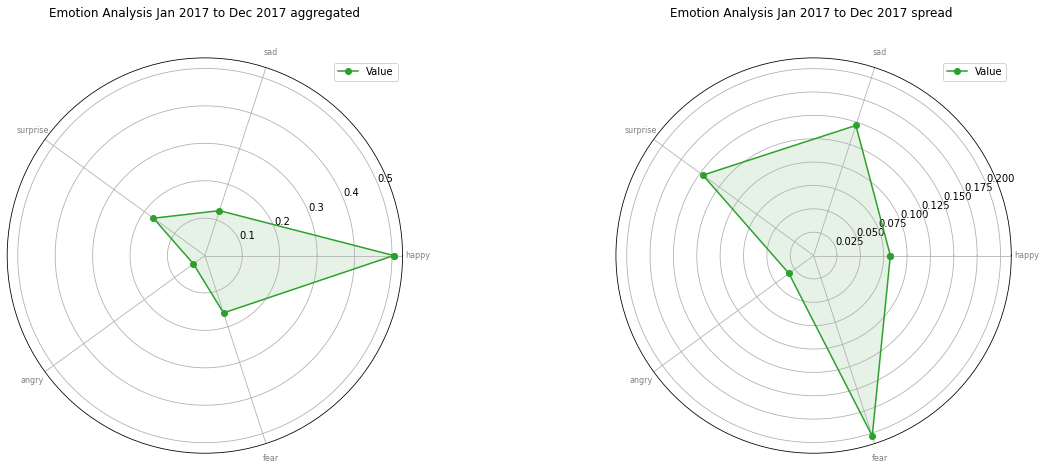

In [ ]:
sentiment_analysis(cleaned_df, state, start_date, end_date)

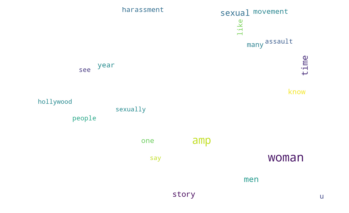

In [ ]:
frequent_words(cleaned_df, start_date, end_date)

In [ ]:
scores(cleaned_df)

[0.01604107860011476, 0.07555609578952946]